In [1]:
from sys import exit 
import numpy as np 
import matplotlib.pyplot as plt 
import keras, tensorflow as tf 
from keras.models import Model 
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, BatchNormalization
import time
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [2]:
img_rows = img_cols = 28 
pred = False
mnist = False
CNN = True

# pathToData = 'mnist/' if mnist else 'emnist/' 
pathToData = 'drive/MyDrive/data/mnist/' if mnist else 'drive/MyDrive/data/emnist/'
num_classes = 10 if mnist else 26
if CNN: num_classes = 36

epochs = 20 

optimizer = 'Adam'
loss = 'mse'
fn_model = pathToData + 'history/' + optimizer + '_' + loss + '/lk3.h5'

# pathToHistory = 'mnist/' if mnist else 'emnist/'
if mnist:
  pathToHistory = 'drive/MyDrive/data/mnist/history/' + optimizer + '_' + loss + '/'
else:
  pathToHistory = 'drive/MyDrive/data/emnist/history/' + optimizer + '_' + loss +'/'

suff = '.txt' 
# Имена файлов, в которые сохраняется история обучения 
fn_loss = pathToHistory + 'loss_' + suff 
fn_acc = pathToHistory + 'acc_' + suff 
fn_val_loss = pathToHistory + 'val_loss_' + suff 
fn_val_acc = pathToHistory + 'val_acc_' + suff  

In [3]:
# Вывод графиков 
def one_plot(n, y_lb, loss_acc, val_loss_acc): 
    plt.subplot(1, 2, n) 
    if n == 1: 
        lb, lb2 = 'loss', 'val_loss' 
        yMin = 0 
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc)) 
    else: 
        lb, lb2 = 'acc', 'val_acc' 
        yMin = min(min(loss_acc), min(val_loss_acc)) 
        yMax = 1.0 
    plt.plot(loss_acc, color = 'r', label = lb, linestyle = '--') 
    plt.plot(val_loss_acc, color = 'g', label = lb2) 
    plt.ylabel(y_lb) 
    plt.xlabel('Эпоха') 
    plt.ylim([0.95 * yMin, yMax]) 
    plt.legend() 

In [4]:
def loadBinData(pathToData, img_rows, img_cols, mnist=mnist): 
    print('Загрузка данных из двоичных файлов...') 
    with open(pathToData + 'imagesTrain.bin', 'rb') as read_binary: 
        x_train = np.fromfile(read_binary, dtype = np.uint8) 
    with open(pathToData + 'labelsTrain.bin', 'rb') as read_binary: 
        y_train = np.fromfile(read_binary, dtype = np.uint8) 
    with open(pathToData + 'imagesTest.bin', 'rb') as read_binary: 
        x_test = np.fromfile(read_binary, dtype = np.uint8) 
    with open(pathToData + 'labelsTest.bin', 'rb') as read_binary: 
        y_test = np.fromfile(read_binary, dtype = np.uint8) 

    # Преобразование целочисленных данных в float32 и нормализация; данные лежат в диапазоне [0.0, 1.0] 
    x_train = np.array(x_train, dtype = 'float32') / 255 
    x_test = np.array(x_test, dtype = 'float32') / 255 

    x_train = x_train.reshape(-1, img_rows, img_cols) # 1 - оттенок серого цвета 
    x_test = x_test.reshape(-1, img_rows, img_cols)

    print('Размер обучающего набора x_train {}'.format(x_train.shape)) 
    print('Размер тестового набора x_test {}'.format(x_test.shape)) 

    if not mnist and not CNN:
        y_train -= 1
        y_test -= 1

    # Преобразование в категориальное представление: метки - числа из диапазона [0, 9](MNIST) или [0, 25](EMNIST) в двоичный вектор размера num_classes 
    # Так, в случае MNIST метка 5 (соответствует классу 6) будет преобразована в вектор [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 
    print('Преобразуем массивы меток в категориальное представление') 

    num_classes = 10 if mnist else 26
    if CNN: num_classes = 36

    if not CNN:
        y_train = tf.keras.utils.to_categorical(y_train, num_classes) 
        y_test = tf.keras.utils.to_categorical(y_test, num_classes) 
        print(y_train[0].shape) # (MNIST) Напечатает: 10
    return x_train, y_train, x_test, y_test 

In [5]:
if CNN:
    # объединяем наборы данных MNIST и EMNIST
    x_train_m, y_train_m, x_test_m, y_test_m = loadBinData('drive/MyDrive/data/mnist/', img_rows, img_cols) 
    x_train_em, y_train_em, x_test_em, y_test_em = loadBinData('drive/MyDrive/data/emnist/', img_rows, img_cols)
    mnist_n, mnist_m= x_train_m.shape[0], x_test_m.shape[0]
    emnist_n, emnist_m = x_train_m.shape[0], x_test_m.shape[0]
    x_train = np.concatenate((x_train_m, x_train_em))
    x_test = np.concatenate((x_test_m, x_test_em))

    y_train_em += 9
    y_test_em += 9

    y_train_m = tf.keras.utils.to_categorical(y_train_m, num_classes) 
    y_test_m = tf.keras.utils.to_categorical(y_test_m, num_classes) 
    y_train_em = tf.keras.utils.to_categorical(y_train_em, num_classes) 
    y_test_em = tf.keras.utils.to_categorical(y_test_em, num_classes) 

    y_train = np.concatenate((y_train_m, y_train_em))
    y_test = np.concatenate((y_test_m, y_test_em))
    print()
    print('Размер получившегося набора x_train: {}'.format(x_train.shape))
    print('Размер получившегося набора x_test: {}'.format(x_test.shape))
else:
    x_train, y_train, x_test, y_test = loadBinData(pathToData, img_rows, img_cols) 
    x_train.shape, y_train.shape
  


Загрузка данных из двоичных файлов...
Размер обучающего набора x_train (60000, 28, 28)
Размер тестового набора x_test (10000, 28, 28)
Преобразуем массивы меток в категориальное представление
Загрузка данных из двоичных файлов...
Размер обучающего набора x_train (124800, 28, 28)
Размер тестового набора x_test (20800, 28, 28)
Преобразуем массивы меток в категориальное представление

Размер получившегося набора x_train: (184800, 28, 28)
Размер получившегося набора x_test: (30800, 28, 28)


5


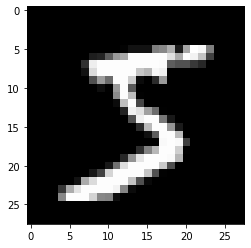

In [6]:
print(np.argmax(y_train[0]))
plt.imshow(x_train[0].reshape(img_rows, img_cols), cmap = 'gray') 
plt.show()

In [7]:
def recall(class_acc):
    classes = class_acc.keys()
    tp = []
    fn = []
    for cls in classes: 
        tp.append(class_acc[cls][0])
        fn.append(class_acc[cls][1] - class_acc[cls][0])
    tp = np.array([tp])
    fn = np.array([fn])

    return tp / (tp + fn)

In [8]:
# Определяем форму входных данных 
input_shape = (img_rows, img_cols, 1) 
# 
# Создание модели нейронной сети 
inp = Input(shape = input_shape, name='input') # Входной слой 
x = inp 


if CNN:
    x = Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', input_shape=input_shape, name='conv2d_1')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='max_pooling2d_1')(x)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', name='conv2d_2')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='max_pooling2d_2')(x)


# Преобразование 2D в 1D 
x = Flatten(name='flatten_1')(x)
# добавляем слой Dropout
x = Dropout(rate=0.2, name='dropout_1')(x)
x = Dense(units=32, activation='relu', name='dense_1')(x)
output = Dense(num_classes, activation = 'softmax', name='pred')(x) 
model = Model(inputs = inp, outputs = output) 
model.summary()
model.compile(optimizer = optimizer, loss = loss, metrics='accuracy') 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0     

In [9]:
# Обучение нейронной сети
start = time.time()
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, 
                    verbose=2, validation_data=(x_test, y_test))
finish = time.time()
print('Elapsed time: {}'.format(finish - start))
print('Модель сохранена в файле', fn_model)
model.save(fn_model)
# Запись истории обучения в текстовые файлы
history = history.history
##for itm in history.items(): print(itm)
with open(fn_loss, 'w') as output:
    for val in history['loss']: output.write(str(val) + '\n')
with open(fn_acc, 'w') as output:
    for val in history['accuracy']: output.write(str(val) + '\n')
with open(fn_val_loss, 'w') as output:
    for val in history['val_loss']: output.write(str(val) + '\n')
with open(fn_val_acc, 'w') as output:
    for val in history['val_accuracy']: output.write(str(val) + '\n')

Epoch 1/20
1444/1444 - 15s - loss: 0.0076 - accuracy: 0.8018 - val_loss: 0.0036 - val_accuracy: 0.9128 - 15s/epoch - 10ms/step
Epoch 2/20
1444/1444 - 7s - loss: 0.0034 - accuracy: 0.9162 - val_loss: 0.0028 - val_accuracy: 0.9331 - 7s/epoch - 5ms/step
Epoch 3/20
1444/1444 - 6s - loss: 0.0028 - accuracy: 0.9332 - val_loss: 0.0024 - val_accuracy: 0.9403 - 6s/epoch - 4ms/step
Epoch 4/20
1444/1444 - 6s - loss: 0.0024 - accuracy: 0.9413 - val_loss: 0.0023 - val_accuracy: 0.9434 - 6s/epoch - 4ms/step
Epoch 5/20
1444/1444 - 6s - loss: 0.0022 - accuracy: 0.9468 - val_loss: 0.0021 - val_accuracy: 0.9474 - 6s/epoch - 4ms/step
Epoch 6/20
1444/1444 - 6s - loss: 0.0021 - accuracy: 0.9491 - val_loss: 0.0021 - val_accuracy: 0.9486 - 6s/epoch - 4ms/step
Epoch 7/20
1444/1444 - 6s - loss: 0.0020 - accuracy: 0.9521 - val_loss: 0.0020 - val_accuracy: 0.9514 - 6s/epoch - 4ms/step
Epoch 8/20
1444/1444 - 6s - loss: 0.0019 - accuracy: 0.9546 - val_loss: 0.0021 - val_accuracy: 0.9486 - 6s/epoch - 4ms/step
Epoch

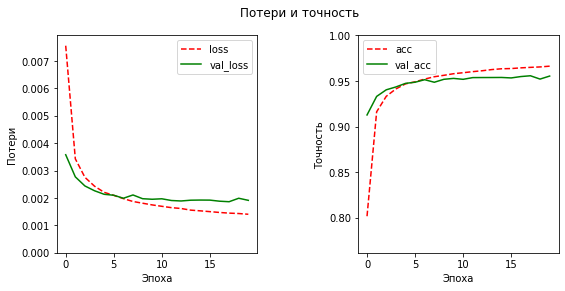

In [10]:
# Вывод графиков обучения 
plt.figure(figsize = (9, 4)) 
plt.subplots_adjust(wspace = 0.5) 
one_plot(1, 'Потери', history['loss'], history['val_loss']) 
one_plot(2, 'Точность', history['accuracy'], history['val_accuracy']) 
plt.suptitle('Потери и точность') 
plt.show() 

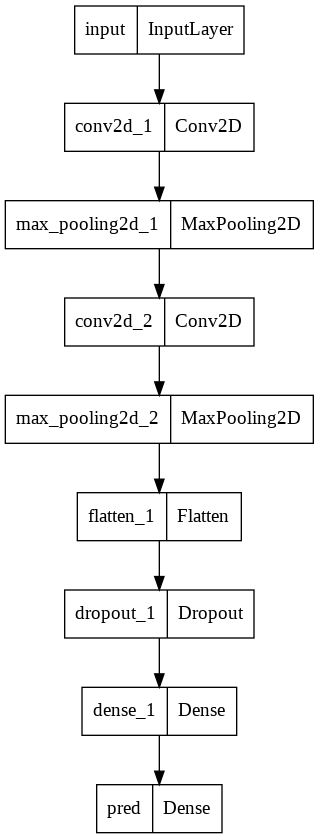

In [11]:
tf.keras.utils.plot_model(model, to_file='cnn_graph.png')

In [12]:
from keras.models import load_model 
model = load_model(fn_model)

In [13]:
# Оценка модели НС на тестовых данных 
score_test = model.evaluate(x_test, y_test, verbose = 1) 
# Вывод потерь и точности 
print('Потери при тестировании:', round(score_test[0], 4)) 
print('Точность при тестировании: {}{}'.format(score_test[1] * 100, '%')) 
score_train = model.evaluate(x_train, y_train, verbose = 1) 
# Вывод потерь и точности 
print('Потери на обучающем наборе:', round(score_train[0], 4)) 
print('Точность на обучющем наборе: {}{}'.format(score_train[1] * 100, '%')) 
# Прогноз 
y_pred = model.predict(x_test)
# Заносим в массив predicted_classes метки классов, предсказанных моделью НС 
# предусмотрим вывод не только цифр, но и букв
if mnist:
    predicted_classes = np.array([np.argmax(m) for m in y_pred])
    true_classes = np.array([np.argmax(m) for m in y_test])
else:
    predicted_classes = np.array([chr(np.argmax(m) + 65) for m in y_pred]) 
    true_classes = np.array([chr(np.argmax(m) + 65) for m in y_test]) 
n_test = len(y_test) 
# Число верно классифицированных изображений 
true_classified = np.sum(predicted_classes == true_classes) 
# Число ошибочно классифицированных изображений 
false_classified = n_test - true_classified 
acc = 100.0 * true_classified / n_test 
print('Точность: {}{}'.format( acc, '%')) 
print('Неверно классифицированно:', false_classified) 

963/963 [==============================] - 2s 2ms/step - loss: 0.0019 - accuracy: 0.9554
Потери при тестировании: 0.0019
Точность при тестировании: 95.53896188735962%
5775/5775 [==============================] - 15s 3ms/step - loss: 0.0011 - accuracy: 0.9733
Потери на обучающем наборе: 0.0011
Точность на обучющем наборе: 97.32738137245178%
Точность: 95.53896103896103%
Неверно классифицированно: 1374
